In [70]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import math
import random
from itertools import count
from collections import namedtuple, deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [80]:
filename = "EURUSD_M1_2023.csv"

df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
# data = df.resample('5min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

df = df.iloc[:100]

data = df.copy()
#Drop NA rows
data = data.dropna(axis=0)

print(data.head(10))
print(data.describe())

                        open     high      low    close
timestamp                                              
2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
             open        high         low       close
count  100.000000  100.000000  100.000000  100.000000
mean     1.069493    1.069675    1.069319    1.069319
std      0.000472    0.000491    0.000505    0.000505
min      1.067880    1.067880    1.067880    1.067880
25%      1.069387    1.069507    1.068998    1.068998
50% 

In [81]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [82]:
from envs import ForexEnv, Actions


window_size = 10
start_index = window_size
end_index = len(data)
# len(data)

env  = ForexEnv(
    df= data,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [83]:
from stable_baselines3 import DQN
import torch.optim as optim

learning_rate = 0.01
optimizer = optim.Adam

model = DQN(
    "MlpPolicy",
    env = env,
    buffer_size=10000, 
    batch_size = 32,
    train_freq = 32,
    gradient_steps = 32,
    target_update_interval = 32,
    learning_rate=learning_rate,
    verbose=1,
    device=device,
)
model.learn(total_timesteps=1000, log_interval=4)

### Fine tuning with adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# model.save("dqn_stable_baseline3_eurusd_2023_5M")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_stable_baseline3_eurusd_2023_5M")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8279     |
|    time_elapsed     | 0        |
|    total_timesteps  | 356      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89       |
|    ep_rew_mean      | -2.71    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8728     |
|    time_elapsed     | 0        |
|    total_timesteps  | 712      |
----------------------------------


In [84]:

#initial state
action_stats = {Actions.Sell: 0, Actions.Buy: 0,}

observation, info = env.reset()

while True:
    action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
# print("Trades:", env.unwrapped.)


action_stats: {<Actions.Sell: 0>: 1, <Actions.Buy: 1>: 88}
info: {'total_reward': -14.098882675170898, 'total_profit': 0.9980740939136599, 'position': <Positions.Long: 1>}


In [85]:
model.save("dqn_stable_baseline3_eurusd_2023_1M")

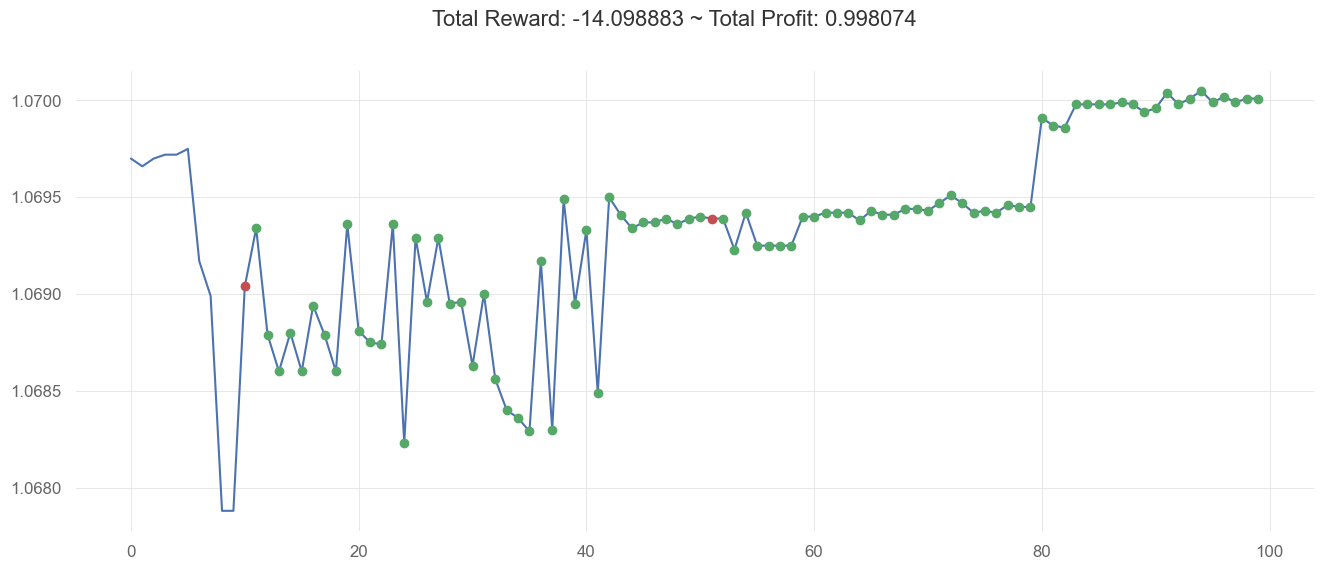

In [86]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [87]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns)

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')

timestamp
2023-01-01 17:45:00    0.0
2023-01-01 17:46:00    0.0
2023-01-01 17:47:00    0.0
2023-01-01 17:48:00    0.0
2023-01-01 17:49:00    0.0
                      ... 
2023-01-01 19:12:00    0.0
2023-01-01 19:13:00    0.0
2023-01-01 19:14:00    0.0
2023-01-01 19:15:00    0.0
2023-01-01 19:16:00    0.0
Length: 88, dtype: float64


ZeroDivisionError: float division by zero